In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [ ]:
training_dataroot = 'data-103-109.csv'
testing_dataroot = 'data-110-112.csv'

Training_dataset = pd.read_csv(training_dataroot)
Testing_dataset = pd.read_csv(testing_dataroot)

In [ ]:
def Split_Label(Training_dataset, Testing_dataset):
  X_train, y_train = Training_dataset.drop(['price', 'latitude', 'elevator', 'janitor', 'closing_year'], axis=1), Training_dataset['price']
  X_test, y_test = Testing_dataset.drop(['price', 'latitude', 'elevator', 'janitor', 'closing_year'], axis=1), Testing_dataset['price']
  #print(X_train)
  return X_train, y_train, X_test, y_test

def Train_Model(X_train, y_train, num_folds):
  model = LinearRegression()
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
  r2_scores = []

  for train_index, val_index in kf.split(X_train):
      X_kf_train, X_kf_val = X_train.iloc[train_index], X_train.iloc[val_index]
      y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]

      model.fit(X_kf_train, y_kf_train)
      y_pred = model.predict(X_kf_val)
      r2 = r2_score(y_kf_val, y_pred)
      r2_scores.append(r2)

  mean_r2 = np.mean(r2_scores)
  print(f"Average R² score: {mean_r2}")

  plt.figure(figsize=(5, 3))
  plt.plot(range(1, num_folds + 1), r2_scores, marker='o', linestyle='-', color='b')
  plt.title(f'R² Scores for {num_folds}-fold Cross-Validation')
  plt.xlabel('Fold')
  plt.ylabel('R² Score')
  plt.xticks(np.arange(1, num_folds + 1))
  plt.grid(True)
  plt.show()

  return model

def Predict(model, X_test, y_test):
  y_pred_test = model.predict(X_test)
  r2_test = r2_score(y_test, y_pred_test)
  mse_test = mean_squared_error(y_test, y_pred_test)
  print(f"R² Score on the test set: {r2_test}")
  print(f"MSE on the test set: {mse_test}")

       longitude  house_age      area  parking_space  bedroom  living_room  \
0       0.865369   0.049550  0.059023           0.00  0.12500     0.095238   
1       0.814559   0.000000  0.047707           0.05  0.06250     0.047619   
2       0.870393   0.001502  0.138733           0.00  0.12500     0.095238   
3       0.870393   0.001502  0.138733           0.00  0.12500     0.095238   
4       0.979599   0.033033  0.078075           0.05  0.09375     0.095238   
...          ...        ...       ...            ...      ...          ...   
47338   0.882880   0.000000  0.045571           0.00  0.06250     0.095238   
47339   0.977352   0.006006  0.122183           0.10  0.12500     0.095238   
47340   0.975994   0.000000  0.131748           0.10  0.09375     0.095238   
47341   0.975994   0.000000  0.126840           0.10  0.09375     0.095238   
47342   0.968103   0.000000  0.108462           0.05  0.09375     0.095238   

       bathroom  residential  property_type_apartment  \
0     

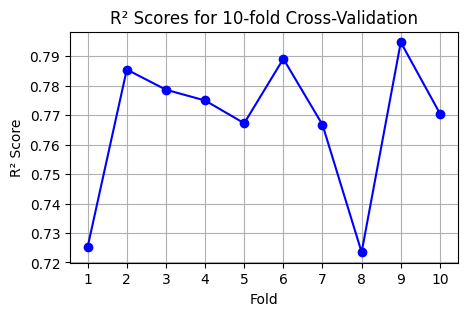

R² Score on the test set: 0.6209859852156505
MSE on the test set: 12756891166279.994


In [ ]:
if __name__ == '__main__':
  X_train, y_train, X_test, y_test = Split_Label(Training_dataset, Testing_dataset)

  num_folds = 10
  model = Train_Model(X_train, y_train, num_folds)

  Predict(model, X_test, y_test)

In [ ]:
def Train_Model(X_train, y_train, num_folds, batch_size=128, num_epochs=250):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(2048, activation='relu', input_dim=X_train.shape[1]),
      tf.keras.layers.Dense(1024, activation='relu'),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(4, activation='relu'),
      tf.keras.layers.Dense(1)  # Output layer
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])

  kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
  r2_scores = []

  for train_index, val_index in kf.split(X_train):
    X_kf_train, X_kf_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]

    history = model.fit(X_kf_train, y_kf_train, epochs=num_epochs, batch_size=batch_size, verbose=0, validation_data=(X_kf_val, y_kf_val))

    y_pred = model.predict(X_kf_val)
    r2_val = r2_score(y_kf_val, y_pred)
    r2_scores.append(r2_val)

    mse = mean_squared_error(y_kf_val, y_pred)

    print(f"R² Score on the validation set: {r2_val}")
    print(f"MSE Score on the validation set: {mse}")

    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

  mean_r2 = np.mean(r2_scores)
  print(f"Average R² score: {mean_r2}")

  return model

def Predict(model, X_test, y_test):
  y_pred_test = model.predict(X_test)
  r2_test = r2_score(y_test, y_pred_test)
  mse_test = mean_squared_error(y_test, y_pred_test)
  print(f"R² Score on the test set: {r2_test}")
  print(f"MSE on the test set: {mse_test}")

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Physical GPUs:", len(physical_devices))

Physical GPUs: 1


       longitude  house_age      area  parking_space  bedroom  living_room  \
0       0.865369   0.049550  0.059023           0.00  0.12500     0.095238   
1       0.814559   0.000000  0.047707           0.05  0.06250     0.047619   
2       0.870393   0.001502  0.138733           0.00  0.12500     0.095238   
3       0.870393   0.001502  0.138733           0.00  0.12500     0.095238   
4       0.979599   0.033033  0.078075           0.05  0.09375     0.095238   
...          ...        ...       ...            ...      ...          ...   
47338   0.882880   0.000000  0.045571           0.00  0.06250     0.095238   
47339   0.977352   0.006006  0.122183           0.10  0.12500     0.095238   
47340   0.975994   0.000000  0.131748           0.10  0.09375     0.095238   
47341   0.975994   0.000000  0.126840           0.10  0.09375     0.095238   
47342   0.968103   0.000000  0.108462           0.05  0.09375     0.095238   

       bathroom  residential  property_type_apartment  \
0     

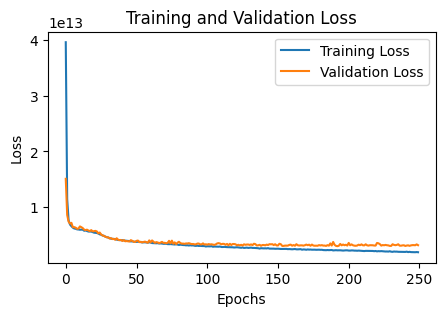

296/296 [==============================] - 1s 2ms/step
R² Score on the validation set: 0.9103164286518612
MSE Score on the validation set: 2453383658478.9146


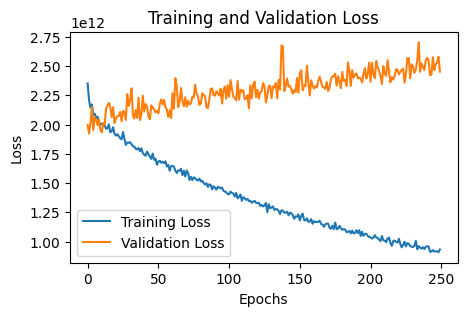

296/296 [==============================] - 1s 2ms/step
R² Score on the validation set: 0.9315732321840697
MSE Score on the validation set: 1925936928405.6301


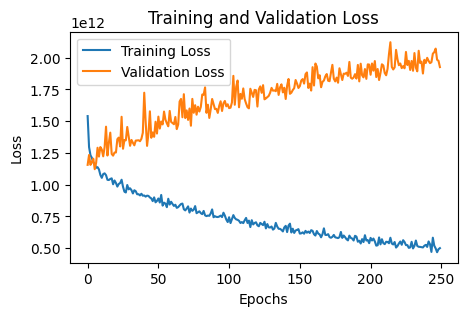

296/296 [==============================] - 1s 2ms/step
R² Score on the validation set: 0.9507217210143408
MSE Score on the validation set: 1364472359677.2856


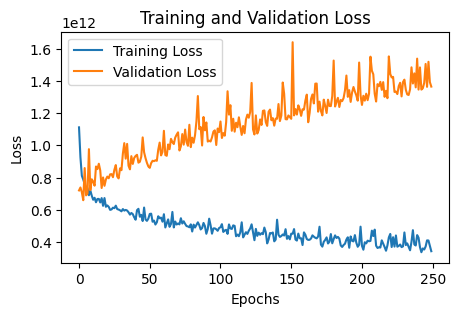

296/296 [==============================] - 1s 2ms/step
R² Score on the validation set: 0.9644027137169858
MSE Score on the validation set: 993093755075.6891


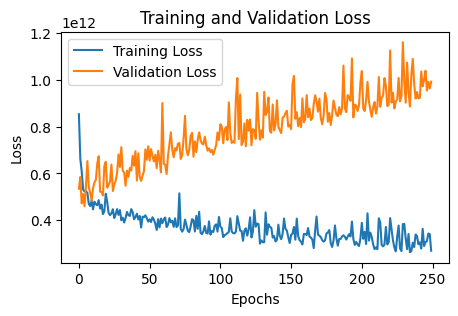

Average R² score: 0.9285274068610232
415/415 [==============================] - 1s 2ms/step
R² Score on the test set: 0.567505714274886
MSE on the test set: 14556935410877.86


In [ ]:
if __name__ == '__main__':
  X_train, y_train, X_test, y_test = Split_Label(Training_dataset, Testing_dataset)

  num_folds = 5
  model = Train_Model(X_train, y_train, num_folds)
  # model.save('NN_model.keras')
  Predict(model, X_test, y_test)

In [ ]:
#model.save('./NN_model.keras')